# Linear generating functions (Chapter 2)

This notebook covers the code and explanation for the following experiments in Chapter 2:
* Example 2A
* Example 2B

==========================================================================

* **Notebook dependencies**:
  * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from torch.distributions import Normal, Uniform

mpl.style.use("seaborn-deep")

## Note on probability distributions

In the code examples throughout this book we rely on the `pyro` library (which itself wraps `pytorch`) to provide probability distribution functions. These distributions can be easily implemented in Python, but it is far more convenient to rely on the `pyro` library versions since they come with much more support for other features we may want like sampling and computing probabilities. Before we use `pyro`, we start by demonstrating how it is possible to construct a normal distribution using just the `numpy` library.

In [5]:
def univariate_gaussian(input, mu, var):
    probability = (1. / np.sqrt(2 * np.pi * var)) * np.exp(-(input - mu)**2 / (2 * var))
    return probability

With this function we can easily generate a normal distribution over a chosen input range. For example, let's pick the range of our input variable, $y$, to be over the range of -5 to 5. Then we can plot this distribution for different means and variances.

In [6]:
y = np.linspace(-5, 5, 250)
prob_1 = univariate_gaussian(y, mu=0, var=0.5)
prob_2 = univariate_gaussian(y, mu=1.5, var=2.5)
prob_3 = univariate_gaussian(y, mu=-1, var=1.5)

<Figure size 432x288 with 0 Axes>

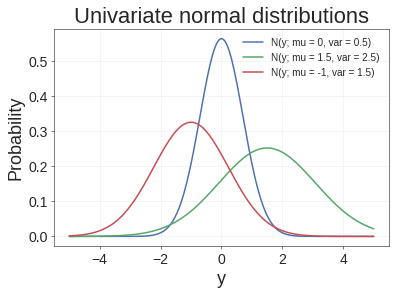

In [7]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(y, prob_1, label="N(y; mu = 0, var = 0.5)")
ax.plot(y, prob_2, label="N(y; mu = 1.5, var = 2.5)")
ax.plot(y, prob_3, label="N(y; mu = -1, var = 1.5)")

ax.set_title("Univariate normal distributions", fontsize=22)
ax.set_xlabel("y", fontsize=18)
ax.set_ylabel("Probability", fontsize=18)

plt.legend()

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

## Linear generating functions

In Chapter 2 we explore a number of different experiments to illustrate the process of hidden state estimation. We emphasize the difficulties involved as the generarating function becomes nonlinear. We explore two variants in this section of Chapter 2:
* Linear and determinisitc
* Linear and probabilistic

In the following code, we will solve Bayes' Theorem with grid approximation where it is assumed that the parameters of the generative model have already been learnt. The aim of the code is for its setup to be as close as possible to the math notation in the accompanying text. 

Section 2.2 described five steps to be used in modeling. We will follow these steps in this notebook:
1. Define the experimental setting (states and outcomes)
2. Define the generative process
3. Define the generative model
4. Learn model parameters
5. Infer hidden states

## Experimental setting

Step 1: **Define the experimental setting (states and outcomes)**.

We will rely on the following variables:
* $x$: The true **hidden state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the states of the generative process ($x$) denote the size of a food  source and the outcomes ($y$) are different levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. 

Step 2: **Define the generative process**.

$$
    \mathscr{E} = 
    \begin{cases}
        G(x) = \beta_1 x + \beta_0   & \text{Generating function}, \\
    \end{cases}
$$

where $G(s)$ is a linear function representing outcomes $y$ generated while in a particular state $x$. In this example, $\beta_0 = 3$ and $\beta_1=2$.

In [8]:
# Define the generating process
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

In the code examples below we are going to discritize the distributions over a grid  in a process called **grid approximation**. Grid approximation will get around having to calculate the integral in the denominator (model evidence). This will only work for relatively small state spaces and processes. This grid, in terms of $x$, ranges from $x_{min} = 0.01$ to $x_{max} = 5$ over $500$ points. Let's visualize the generating function under this setup:

In [9]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)

<Figure size 432x288 with 0 Axes>

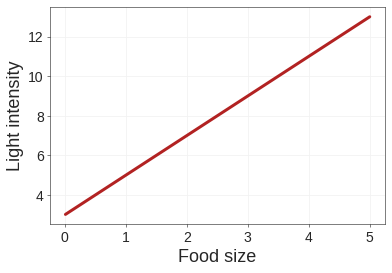

In [10]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(x_range, G(x_range, beta_0=3, beta_1=2),
        c="#b22222",
        linewidth=3)

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

## Experiment 2A: Linear deterministic generative process

With the generating function defined we can begin the next step.

Step 3: **Define the generative model**. The model, $\mathcal{M}$ is represented as follows:

$$
\mathcal{M} = 
\begin{cases}
    p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; \mu_y, \sigma^2_y) \approx \delta(x)& \text{Likelihood} \\
    p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; \mu_x, \sigma^2_x) & \text{Prior on } x \\
    \mu_y = \beta_0 + \beta_1 x & \text{Generating function} \\
    \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \} & \text{Linear parameters} \\
    \phi := \left \{\sigma^2_y \rightarrow 0, a_x = 0, b_x = 5 \right \} & \text{Other parameters} 
\end{cases}
$$

As a reminder, in this demonstration we have assumed that learning has already occurred so the parameters will be set in advance, as seen in the entry for $\text{linear parameters}$ and $\text{Other parameters}$ above. Therefore, we are skipping Step 4: **Learn model parameters** for this chapter. We will choose a likelihood that has zero variance for this demonstration so that it is deterministic. Without uncertainty, the distribution's density reduces to a point, which we can describe with a Dirac $\delta$ function. We can approximate this in our example by simple making the variance of the likelihood tiny. The prior distribution will be **improper** so that it does not have an effect on the inference process. 

In the code that follows, we assume that we have a single observation, set at $10$ generated by a single state. In later examples, we will use multiple observations.

**Note**: By default, the `pytorch/pyro` distributions will calculate the *log* probability rather than a probability. Later we will find that this is numerically more stable for downstream calculations and preferrable. At the moment we are not concerned with this and we will also want to be plotting these functions and so we will remove the log transformations with `np.exp()`. 

In [11]:
# Set up modeling objects
obs                = torch.Tensor((10,))              # Convert to tensor since this is required by the pyro Normal and Uniform functions
likelihood_mean    = G(x_range, beta_0=3, beta_1=2)   # Genearting function is the mean of the Gaussian likelihood
likelihood_noise   = float(1./100)                    # A tiny variance approximates a Dirac delta function
prior_a            = x_min
prior_b            = x_max + 0.01

# Define the components of the generative model
log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise)
log_prior          = Uniform(low=prior_a, high=prior_b)

Now we perform Step 5: **Infer hidden states** and plot.

Remember that the likelihood function starts with the conditional distribution $p(y \mid x)$ and then we hold $y$ fixed (passing in the observation) and vary $x$ across its range (passing in `x_range` as we did above).

In [12]:
# Calculate posterior
likelihood   = np.exp(log_likelihood.log_prob(obs))  # Call np.exp() to undo the log transformation
prior        = np.exp(log_prior.log_prob(x_range))   # Call np.exp() to undo the log transformation
gen_model    = likelihood * prior                    # p(x, y)  = p(y | x)p(x)
evidence     = torch.sum(gen_model)                  # p(y)     = integral_x of p(x, y); approximated in our grid with a sum
posterior    = gen_model / evidence                  # p(x | y) = p(x, y) / p(y)

Plot the results:

<Figure size 432x288 with 0 Axes>

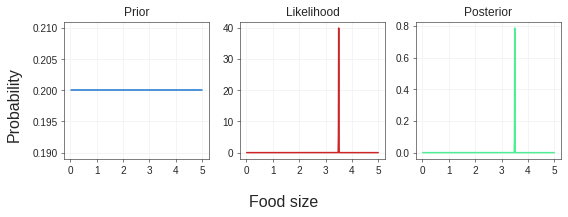

In [13]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

We can see that the likelihood gives us a "*credibility*" (i.e. not a probability) about the probability of generating the data we observed over the range of $x$. To get the *probability* of observing that data we need to normalize the likelihood after multiplying by the prior. More detail on the likelihood is given in Experiment 2B.

Now to see how good our estimate is, let's first calculate the posterior mode which corresponds to the most likely value of $x$ given the observed data.

In [14]:
# Note: When calculating the argmax it's in terms of the scale of the grid which ranges from 0.01-500. 
# But we want food size in terms of 0-5 so the adjustment of adding one and dividng by 100 is necessary to get the scales to line up.
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the food size when the observed light intensity is 10.')

The posterior mode is 3.5. This is the food size when the observed light intensity is 10.


In this deterministic case, we could have obtained this answer a different way. If we invert the generating function $y = 2x+3$ we obtain $x = \frac{y-3}{2}$. Plugging $10$ into this equation we see that $x=3.5$. When probability is added into our model (next experiment), we can think of Bayesian inference as inverting our generating function under conditions of uncertainty.

## Experiment 2B: Linear, probabilistic generative process

In this next experiment and beyond we will omit references to the specific steps of our modeling process and just define the pieces we need. 

Generative process:
$
\mathscr{E} = 
\begin{cases}
    \mu = \beta_1 x + \beta_0                & \text{Generating function} \\
    y \sim \mathcal{N}(\mu, \sigma^2 = 1)    & \text{Gaussian noise} \\
\end{cases}
$

We use $\beta_1 = 2$ and $\beta_0 = 3$. Now the observation is "corrupted" or made probabilistic due to Gaussian noise. Let's set up the generative process in code form so that we can visualize it. In setting up the generative process we assume that points are generated according to the generating function with added Gaussian noise. In the code below, we define `E` as the generative process and then sample it in the next code cell.

In [15]:
# Set seed
torch.manual_seed(5454)
mu = G(x_range, beta_0=3, beta_1=2)
E = Normal(loc=mu, scale=0.5)

<Figure size 432x288 with 0 Axes>

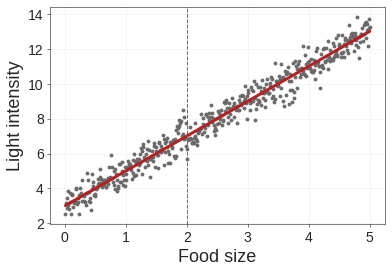

In [16]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range.tolist(), [G(elem, beta_0=3, beta_1=2) for elem in x_range],
        c="#B22222", linewidth=3)

# Noisy samples
ax.scatter(x_range.tolist(), E.sample().tolist(),
        c="#696969", s=8)

ax.axvline(x=2, linestyle="dashed", linewidth=1)

# Axis labels and styling
ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)


$
\mathcal{M} = 
\begin{cases}
    p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; \mu_y, \sigma^2_y) & \text{Likelihood} \\
    p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; \mu_x, \sigma^2_x) & \text{Prior on } x \\
    \mu_y = \beta_0 + \beta_1 x & \text{Generating function} \\
    \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Parameters} \\ 
    \phi := \left \{\sigma^2_y = 0.25, \sigma^2_x = 0.25, \mu_x = 4 \right \} & \text{Hyperparameters}
\end{cases}
$

Now we have a proper distribution for the likelihood and prior. Both are normal distributions without any of the degenerate properties introduced in the previous example. Once again, we have assumed that the parameters are given under the assumption that they have been learned already. Let's examine the likelihood and prior and understand their interpretation.

**Important note**: In the code, we show the variance for the Gaussian distribution parameter. But the `Pyro` functions for Gaussian distributions use standard deviation instead of variance so we take the square root in the code below.

### The likelihood

So far, we have described the likelihood as a *function* rather than a probability distribution. The reason for this is that although we are starting with the conditional distribution $p(y \mid x)$ we will treat it in a unique way which we call the "likelihood function". Specifically, the likelihood function $\mathcal{L}(x)$, is a function of $x$ instead of $y$. What this means is that we start with an observation $y$ and then ask: "If we input the full range of $x$ into this function, what will the resulting curve look like?". Let's generate this curve first and then interpret its meaning.

In [17]:
# Set up modeling objects
obs = torch.Tensor((7,))    # Convert to tensor

# We will take the likelihood at 5 different points of x. Initialize an empty array that we can fill in.
likelihoods           = np.zeros(5)
likelihood_noise      = 0.5

# What is the probability for each of these five points?
for i in range(1, 6):
    likelihood_mean = G(i, beta_0=3, beta_1=2)
    log_likelihood = Normal(loc=likelihood_mean, scale=likelihood_noise)
    likelihood = np.exp(log_likelihood.log_prob(obs))   # Likelihood at p(y = 7 | x = i)
    likelihoods[i-1] = likelihood
    print(f"The likelihood when y={obs.numpy()[0]} and x={i} is: {likelihood.numpy()[0]}.")

The likelihood when y=7.0 and x=1 is: 0.0002676605654414743.
The likelihood when y=7.0 and x=2 is: 0.7978845834732056.
The likelihood when y=7.0 and x=3 is: 0.0002676605654414743.
The likelihood when y=7.0 and x=4 is: 1.010453639570209e-14.
The likelihood when y=7.0 and x=5 is: 4.2927648976280707e-32.


Notice in the above output that we have held $y$ fixed at whatever the observation was and then we have passed in values of $x = \left \{1, 2, 3, 4, 5 \right \}$. This is why the likelihood is a function of $x$: we have varied $x$ while keeping $y$ constant. Next, lets plot these values.

<Figure size 432x288 with 0 Axes>

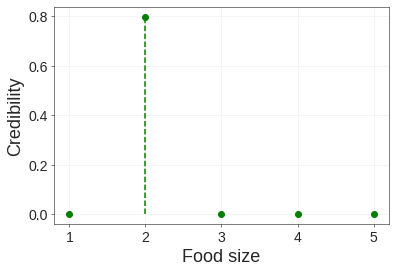

In [18]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
for i in range(1, 6):
    ax.stem(i, likelihoods[i-1], linefmt="g--", markerfmt="go")

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Credibility", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

We have only picked five points and it seems to tell us something. Let's improve this chart by picking a few more points around $2$ and adding it to the plot. Let's pick $x=1.5$ and $x=2.5$ and see how that changes the plot.

In [19]:
likelihood_x15 = np.exp(Normal(
    loc=G(1.5, beta_0=3, beta_1=2), 
    scale=likelihood_noise).log_prob(obs).numpy())[0]   # Likelihood at x=1.5

likelihood_x25 = np.exp(Normal(
    loc=G(2.5, beta_0=3, beta_1=2), 
    scale=likelihood_noise).log_prob(obs).numpy())[0]   # Likelihood at x=2.5

# Insert them into the likelihoods array at the correct positions
likelihoods = np.insert(likelihoods, 1, likelihood_x15)
likelihoods = np.insert(likelihoods, 3, likelihood_x25)

In addition, let's go ahead and plot over the entire range of $x$ in our grid (0.01 - 5, with 500 points).

<Figure size 432x288 with 0 Axes>

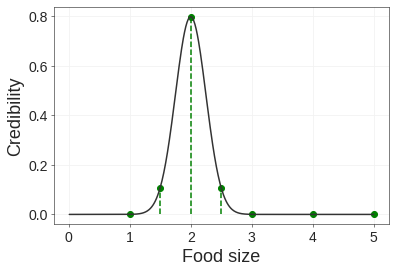

In [20]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

x_points = [1, 1.5, 2, 2.5, 3, 4, 5]

# Plot linear generating function on canvas
for idx, i in enumerate(x_points):
    ax.stem(i, likelihoods[idx], linefmt="g--", markerfmt="go")
    
# All likelihoods
likelihoods_x_range = np.exp(Normal(
    loc=G(x_range, beta_0=3, beta_1=2), 
    scale=likelihood_noise).log_prob(obs).numpy())   # Likelihood at all points in the grid
    
ax.plot(x_range, likelihoods_x_range, c="#333333")

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Credibility", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

The area under the curve is an *unnormalized probability* - it does not sum to $1$! This is why this is not a valid probability distribution. Varying the values of $x$ in this manner creates a curve does not have the properties of a probability distribution. We instead call this the *likelihood* rather than the *probability*. Instead, we could think of the y-axis as telling us a degree of credibility. It seems that $2$ is the most credible hidden state that could have generated the observation $y=7$. However, we still do not know the *probability* of generating this value under our model. We will come to this shortly when we perform Bayesian inference to obtain the conditional distribution of $p(x \mid y)$. Since we know the inverse equation we can calculate directly to check if this makes sense that $x=2$.

$x = \frac{y-3}{2}$. So, $x = \frac{7-3}{2} = 2$. But, due to the uncertainty we have added in with the likelihood noise, the model show a reduction of credibility around $2$, unlike the deterministic case.

### The prior

We can interpret the prior as the agent's previous experience with this state. From prior knowledge, before seeing new data, it has a sense of what the mean is typically centered around. The prior can influence our hidden state estimate as we will see clearly in a moment. In this case, because there is only one sample of $y$ it will have a particularly strong effect on our "belief" (probability) of the hidden state that generated the observation.

### Inferring the probability of the hidden state

Equipped with all the modeling components, we can begin the inference process as we did in Experiment 2A. In the modeling process, we will once again use a single sample, one observation from the generative process of $y=7$. 

In [21]:
# Observed light intensity
obs                 = torch.tensor([7,])

# Set up parameters
likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
likelihood_noise   = 0.5
prior_mean         = 4
prior_noise        = 0.5

# Set up generative model
log_likelihood  = Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(obs).numpy()
log_prior       = Normal(loc=prior_mean, scale=prior_noise).log_prob(x_range).numpy()
likelihood      = np.exp(log_likelihood)
prior           = np.exp(log_prior)

# Bayesian inference
gen_model       = likelihood * prior
evidence        = np.sum(gen_model, axis=0)
posterior       = gen_model / evidence

<Figure size 432x288 with 0 Axes>

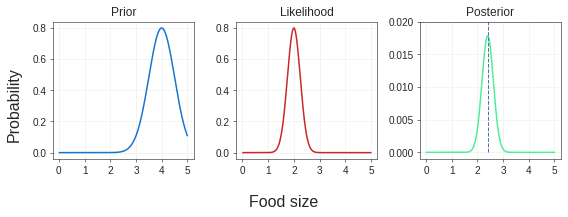

In [27]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].vlines(x=(np.argmax(posterior) + 1) / 100, ymin=0, ymax=0.020, linestyles="dashed", linewidth=1)
axes[2].set_ylim([-0.001, 0.02])

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [28]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 7.')

The posterior mode is 2.4. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 7.


Using the inverse equation for the generating function we can calculate what the true state should be. We expect $x=2$. However, according to the posterior mode estimate above, the posterior is right-shifted to $2.4$. We can say that agent's belief about the hidden state is that it is $2.4$ but the true state is $2$. This illustrates the effect of the prior on our prediction. Past experience can dictate the future belief. Since the posterior is a a kind of average between the prior and likelihood, the prior's right-shifted mean ends up producing a posterior mean between the means of the likelihood and prior.

## The effect of precision

In [42]:
def bayes(mu_y, mu_x):
    # Observed light intensity
    obs                 = torch.tensor([7,])

    # Set up parameters
    likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
    likelihood_noise   = mu_y
    prior_mean         = 4
    prior_noise        = mu_x

    # Set up generative model
    log_likelihood  = Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(obs).numpy()
    log_prior       = Normal(loc=prior_mean, scale=prior_noise).log_prob(x_range).numpy()
    likelihood      = np.exp(log_likelihood)
    prior           = np.exp(log_prior)

    # Bayesian inference
    gen_model       = likelihood * prior
    evidence        = np.sum(gen_model, axis=0)
    posterior       = gen_model / evidence
    
    return prior, likelihood, posterior

In [51]:
prior1, likelihood1, posterior1 = bayes(mu_y=2, mu_x=0.1)
prior2, likelihood2, posterior2 = bayes(mu_y=0.1, mu_x=2)

<Figure size 432x288 with 0 Axes>

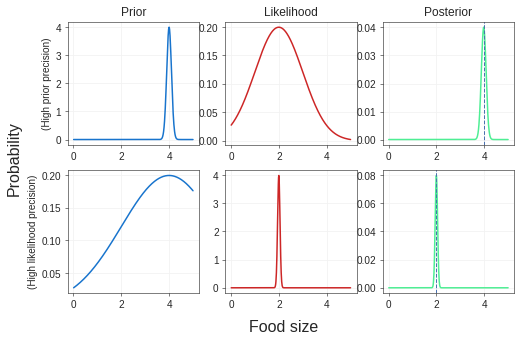

In [59]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(2,3, facecolor=(1,1,1), figsize=(8,5))

# Top row
axes[0,0].plot(x_range.tolist(), prior1, c="#1874cd")        # Prior
axes[0,1].plot(x_range.tolist(), likelihood1, c="#cd2626")   # Likelihood
axes[0,2].plot(x_range.tolist(), posterior1, c="#4eee94")    # Posterior

# Bottom row
axes[1,0].plot(x_range.tolist(), prior2, c="#1874cd")        # Prior
axes[1,1].plot(x_range.tolist(), likelihood2, c="#cd2626")   # Likelihood
axes[1,2].plot(x_range.tolist(), posterior2, c="#4eee94")    # Posterior

# Posterior vertical line
axes[0,2].axvline(x=(np.argmax(posterior1) + 1) / 100, ls="dashed", lw=1)
axes[1,2].axvline(x=(np.argmax(posterior2) + 1) / 100, ls="dashed", lw=1)

# Titles
axes[0,0].set_title("Prior")
axes[0,1].set_title("Likelihood")
axes[0,2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Descriptions
axes[0,0].set_ylabel("(High prior precision)")
axes[1,0].set_ylabel("(High likelihood precision)")

# Cosmetic changes and axes ranges
for ax in axes.reshape(-1):
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
# fig.legend(loc="upper right", frameon=True, bbox_to_anchor=(0.99, 0.88))